In [40]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython import display
from lateral_connections.torch_utils import *
from lateral_connections import LateralModel, VggModel, CustomImageDataset

model_path = 'models/VGG19_normalized_avg_pool_pytorch'
vm = VggModel(model_path, torch.device('cuda'), important_layers=['relu1_1', 'pool1', 'pool2'])

def torch_transform(img):
    return img.float()

ds = CustomImageDataset('images/geometric_dataset/annotations.csv', image_transform=torch_transform)

model = LateralModel(vgg_model=vm, dataset=ds, distance=2, num_output_repetitions=4, alpha=0.1, beta=0.5, gamma=10, eta=0.1, num_cell_dynamic_iterations=1)

def plot_name_by_model_param(model, iteration=0):
    return f"images__debug/d{str(model.d)}_rep{str(model.n)}_k{str(model.k)}_prd{str(model.prd)}_alpha{str(model.alpha)}_eta{str(model.eta)}__it{iteration}.png"

In [2]:
def print_debug():
    """
    img_index = np.random.randint(len(ds))
    #img_index = 1400

    img,_ = ds[img_index]
    print("Image at: ", ds.df.iloc[img_index].file_path)

    model.forward(img, update=False)
    """
    
    #indices = [384, 256, 128, 0, 1, 2, 3, 4]
    indices = [128, 0, 1, 2, 3, 4, 5, 6]
    #indices = range(8)
    num_fms = 8
    plot_scale = 3

    fig, axs = plt.subplots(4,num_fms,figsize=(num_fms*plot_scale, 4*plot_scale))
    
    for f in range(num_fms):
        data0 = torch.swapaxes(torch.swapaxes(img, 0, 2), 0, 1).cpu().numpy().astype(int)
        axs[0, f].imshow(data0, vmin=0, vmax=1)
        axs[0, f].set_title(f"Input Image")

        data1 = model.A[0,indices[f],:,:].cpu().detach().numpy()
        axs[1,f].imshow(data1, vmin=0, vmax=np.max(model.A.cpu().numpy()))
        axs[1,f].set_title(f"Activation of FM #{indices[f]} (Max: {int(np.max(data1))})")

        data2 = model.L[indices[f],:,:].cpu().detach().numpy()
        #axs[2,f].imshow(data2, vmin=0, vmax=1)
        axs[2,f].imshow(data2, vmin=0, vmax=np.max(model.L.cpu().numpy()))
        axs[2,f].set_title(f"Lateral Activity of FM #{indices[f]} (Max: {int(np.max(data2))})")

        #axs[3,f].imshow(data1*data2, vmin=0, vmax=1)
        data3 = model.O[-1,indices[f],:,:].cpu().detach().numpy()
        axs[3,f].imshow(data3, vmin=0, vmax=1)
        #axs[3,f].imshow(data3, vmin=0, vmax=np.max(model.O.cpu().numpy()))
        axs[3,f].set_title(f"Output for FM #{indices[f]} (Max: {int(np.max(data3))})")

    plt.tight_layout()
    return fig

def kernel_debug():
    num_input_feature_maps = 8
    num_output_feature_maps = 8
    plot_scale = 3

    fig, axs = plt.subplots(num_output_feature_maps, num_input_feature_maps, figsize=(plot_scale*num_output_feature_maps,plot_scale*num_input_feature_maps))

    for i in range(num_output_feature_maps):
        for j in range(num_input_feature_maps):
            data = minmax_on_fm(model.K[i, j, :, :]).cpu().detach().numpy()
            #axs[i,j].imshow(data, vmin=0, vmax=0.1)
            axs[i,j].imshow(data, vmin=0, vmax=np.max(data))
            axs[i,j].set_title(f"Kernel K_{j},{i}  (Max: {round(float(np.max(data)), 2)})")
    plt.tight_layout()
    return fig
    
def plot_lateral(img):
    fig, axs = plt.subplots(1, 6, figsize=(6*3, 3))
    
    axs[0].imshow(torch.swapaxes(torch.swapaxes(img, 0, 2), 0, 1).cpu().numpy().astype(int))
    axs[0].set_title('Input Image')
    
    for i in range(5):
        data2 = model.L[i,:,:].cpu().detach().numpy()
        axs[i+1].imshow(data2, vmin=0, vmax=np.max(model.L.cpu().numpy()))
        axs[i+1].set_title(f"Lateral Activity of FM #{i} (Max: {int(np.max(data2))})")
    plt.tight_layout()
    return fig
    
def test_fig(data, vmin=0, vmax=1):
    fig = plt.figure(figsize=(12,8))
    plt.imshow(data, vmin=vmin, vmax=vmax)
    #plt.colorbar()
    plt.xlabel('Iterations')
    """
    plt.clim([0,data.max()])
    plt.ylabel('Feature Maps')
    plt.suptitle('History "Mean"')
    """
    plt.tight_layout()
    return fig
    
#print_debug()

In [3]:
num_epochs = 1024

import wandb
wandb.init(project="MT_LateralConnections", entity="lehl")

M_hist = torch.zeros(size=(num_epochs, model.n * 128))
S_hist = torch.zeros(size=(num_epochs, model.n * 128))

pbar = tqdm(range(num_epochs))
for i in pbar:
    img_id = np.random.randint(len(ds))
    img, label = ds[img_id]
    pbar.set_description(f"Processing #{img_id} ({ds.labels[label]})")
    
    model.forward(img)
    
    
    wandb_dict = {
        'M': model.M.cpu().numpy(),
        'S': model.S.cpu().numpy(),
        'mu': model.mu.cpu().numpy(),
        'mean_M': np.mean(model.M.cpu().numpy()),
        'mean_S': np.mean(model.S.cpu().numpy()),
        'mean_mu': np.mean(model.mu.cpu().numpy())
    }
    
    if (i % 16) == 0:
        #wandb_dict['S_chart'] = test_fig(torch.transpose(S_hist,0,1))
        #wandb_dict['M_chart'] = test_fig(torch.transpose(M_hist,0,1), vmax=0.03) 
        #wandb_dict['lateral_activity_chart'] = plot_lateral(img)
        wandb_dict['debug_plot'] = print_debug()
        wandb_dict['kernel_plot'] = kernel_debug()
    
    wandb.log(wandb_dict)
    plt.close('all')
    
    M_hist[i, :] = model.M
    S_hist[i, :] = model.S
    
    #data_kc = model.K_change.cpu().numpy()
    #print(f"K_change: {round(float(np.min(data_kc)),2)} {round(float(np.mean(data_kc)),2)} {round(float(np.max(data_kc)),2)}")
    
    """
    if (i % 16) == 0:
        print('Epoch ' + str(i))
        print('===' * 30)
        print_debug()
        plt.savefig(plot_name_by_model_param(model, i))
        plt.show()
    """ 

wandb: Currently logged in as: lehl (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/1024 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


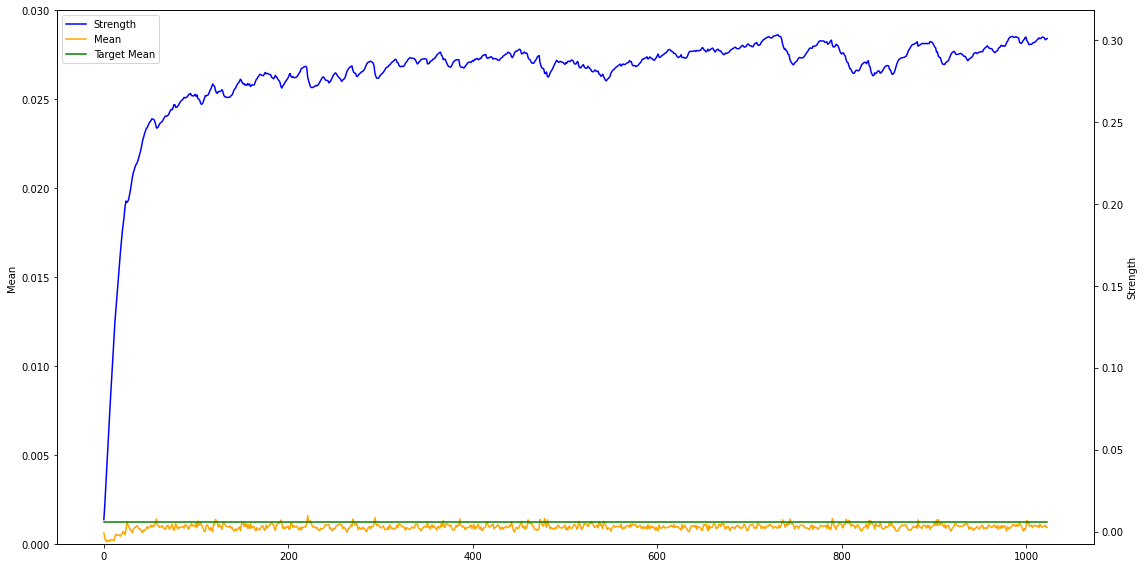

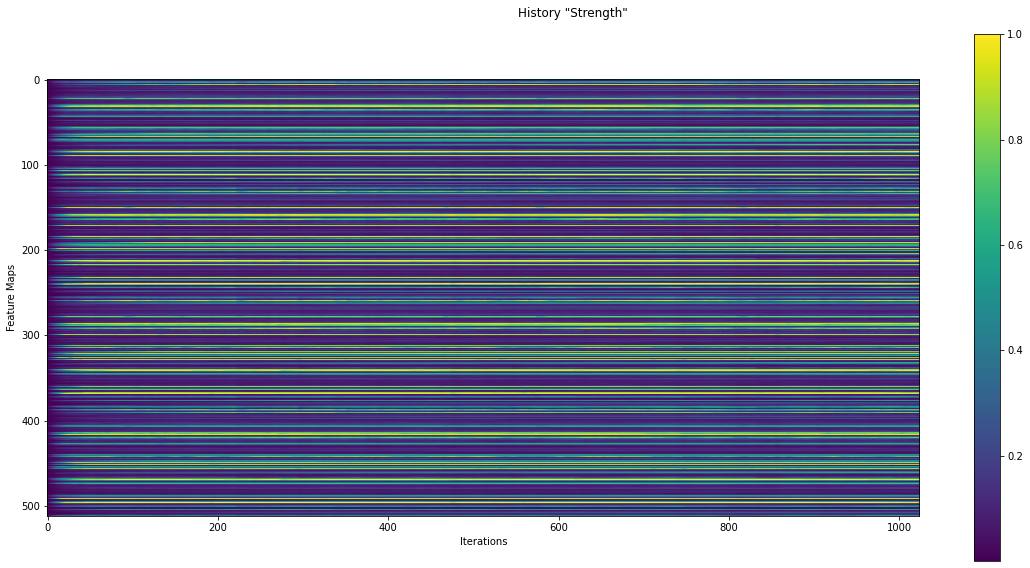

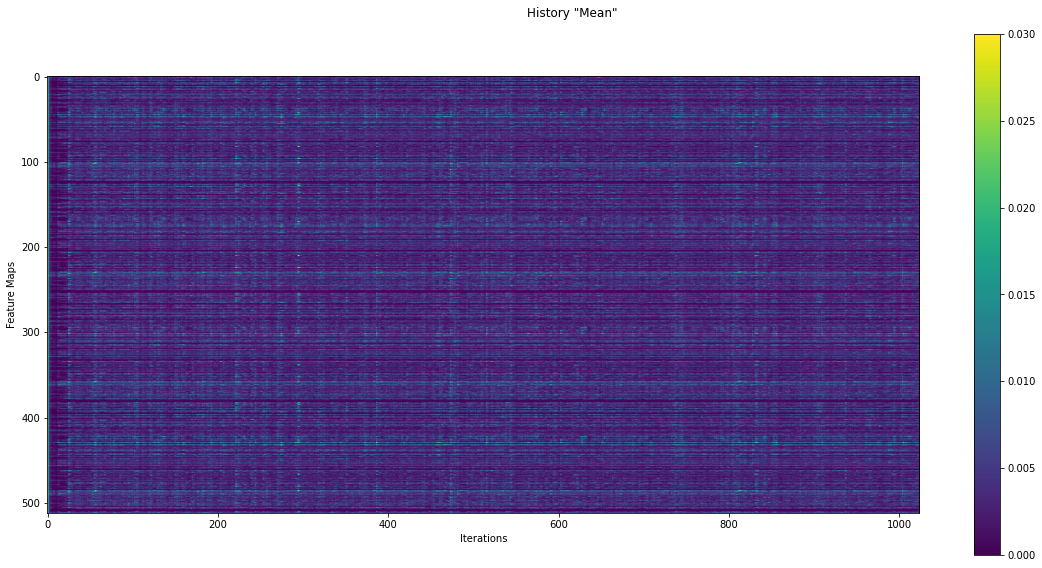

In [4]:
plot_divisor = 16
fig_size = (16,8)
save = False

fig, ax = plt.subplots(figsize=fig_size)
ax2 = ax.twinx()
x = np.arange(M_hist.shape[0])
#l1 = ax.plot(x, np.mean(M_hist.numpy(),axis=1) / np.mean(S_hist.numpy(),axis=1), color='yellow')
l3 = ax.plot(x, np.mean(M_hist.numpy(),axis=1), color='orange')
l4 = ax.plot(x, np.ones(shape=x.shape) * np.mean(model.mu.cpu().numpy()), color='green')
ax.set_ylabel('Mean')
ax.set_ylim([0, 0.03])
l2 = ax2.plot(x, np.mean(S_hist.numpy(),axis=1), color='blue')
ax2.set_ylabel('Strength')
ax2.legend(l2 + l3 + l4, ['Strength', 'Mean', 'Target Mean'])
plt.tight_layout()
if save:
    plt.savefig('mean_strength_evolution__2048it__alpha' + str(model.alpha) + '_beta' + str(model.beta) + '_gamma' + str(model.gamma) + '.png')
plt.show()

fig = plt.figure(figsize=fig_size)
plt.imshow(torch.transpose(S_hist,0,1))
plt.colorbar()
plt.xlabel('Iterations')
plt.ylabel('Feature Maps')
plt.suptitle('History "Strength"')
plt.tight_layout()
if save:
    plt.savefig('strength_histogram__2048it__alpha' + str(model.alpha) + '_beta' + str(model.beta) + '_gamma' + str(model.gamma) + '.png')
plt.show()

fig = plt.figure(figsize=fig_size)
plt.imshow(torch.transpose(M_hist,0,1) / torch.transpose(S_hist,0,1))
plt.colorbar()
plt.clim([0,0.03])
plt.xlabel('Iterations')
plt.ylabel('Feature Maps')
plt.suptitle('History "Mean"')
plt.tight_layout()
if save:
    plt.savefig('mean_histogram__2048it__alpha' + str(model.alpha) + '_beta' + str(model.beta) + '_gamma' + str(model.gamma) + '.png')
plt.show()




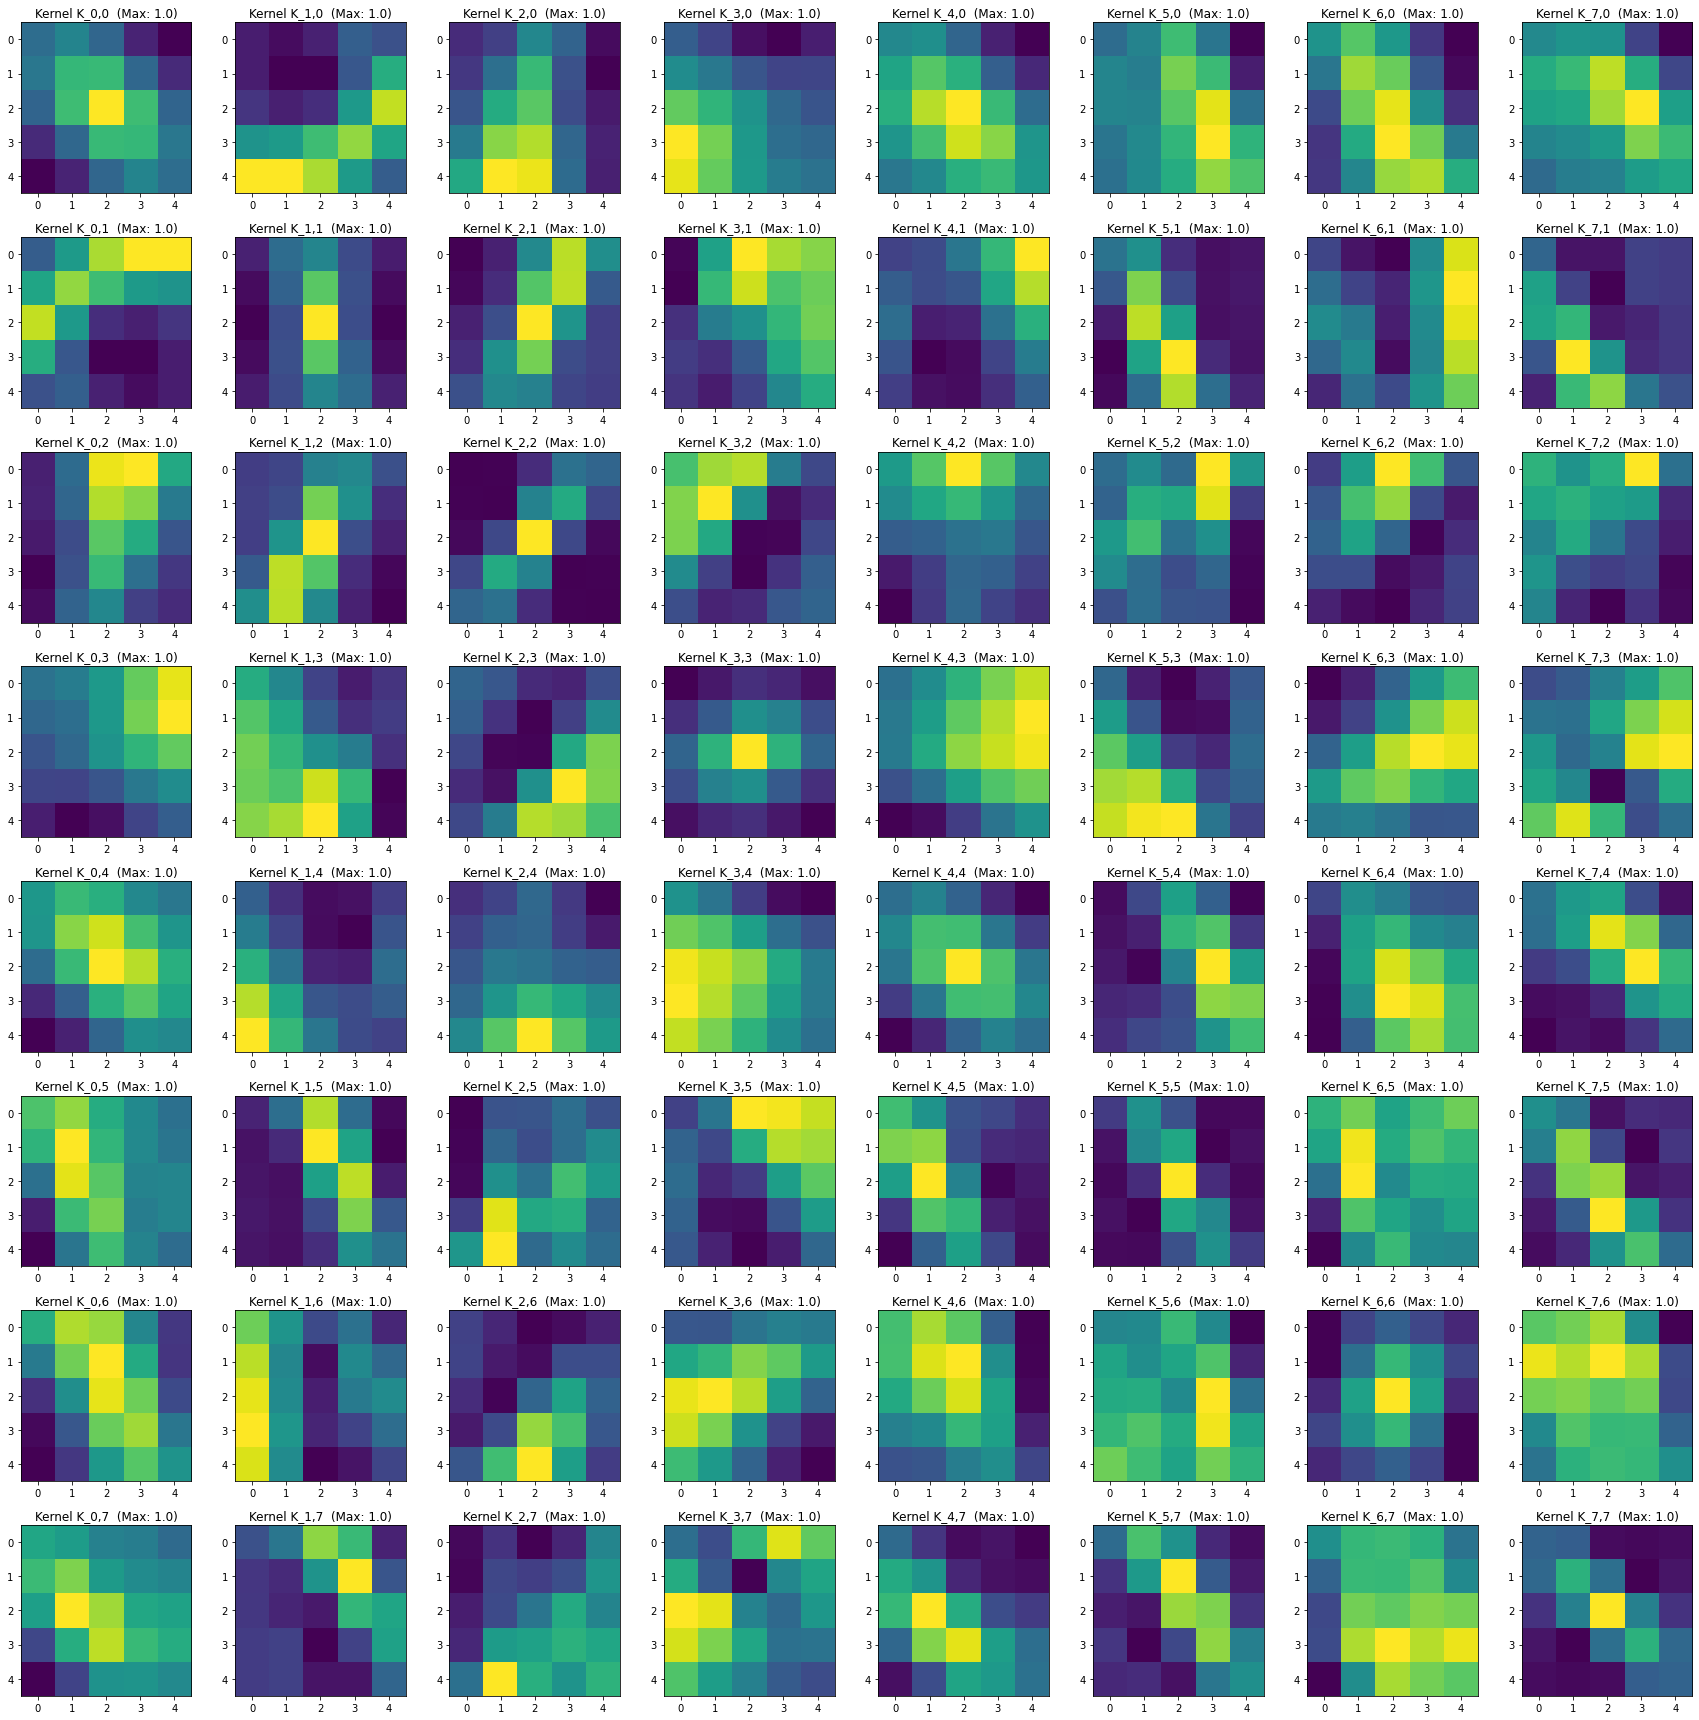

In [38]:
num_input_feature_maps = 8
num_output_feature_maps = 8
plot_scale = 3

fig, axs = plt.subplots(num_output_feature_maps, num_input_feature_maps, figsize=(plot_scale*num_output_feature_maps,plot_scale*num_input_feature_maps))

for i in range(num_output_feature_maps):
    for j in range(num_input_feature_maps):
        data = minmax_on_fm(model.K[i, j, :, :]).cpu().detach().numpy()
        #axs[i,j].imshow(data, vmin=0, vmax=0.1)
        axs[i,j].imshow(data, vmin=0, vmax=np.max(data))
        axs[i,j].set_title(f"Kernel K_{j},{i}  (Max: {round(float(np.max(data)), 2)})")
plt.tight_layout()

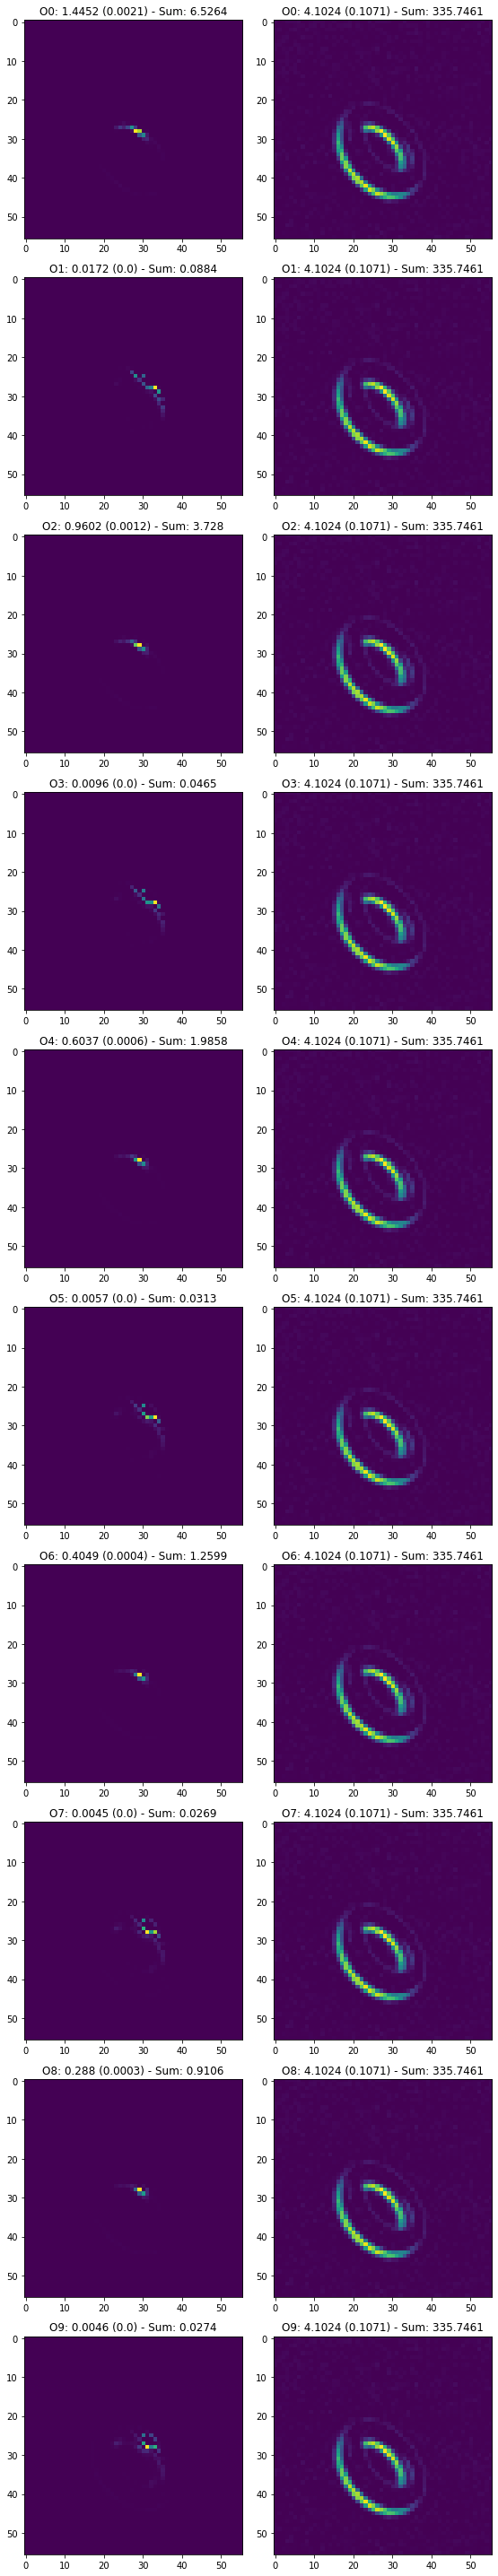

In [6]:
prec = 4
plot_scale = 4
fig, axs = plt.subplots(model.t_dyn, 2, figsize=(2*plot_scale, model.t_dyn*plot_scale))


for i in range(model.t_dyn):
    do = model.O[i, 0, :, :].cpu().numpy()
    axs[i, 0].imshow(do, vmin=0, vmax=np.max(do))
    axs[i, 0].set_title(f"O{str(i)}: {round(float(np.max(do)), prec)} ({round(float(np.mean(do)), prec)}) - Sum: {round(float(np.sum(do)),prec)}")
    
    da = model.A[i, 0, :, :].cpu().numpy()
    axs[i, 1].imshow(da, vmin=0, vmax=np.max(da))
    axs[i, 1].set_title(f"O{str(i)}: {round(float(np.max(da)), prec)} ({round(float(np.mean(da)), prec)}) - Sum: {round(float(np.sum(da)),prec)}")
    
plt.tight_layout()
                        